In [12]:
import Cluster
import cProfile
import partition
import pickle
import strip
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
TILE_SIZE = 25

In [9]:
## Loading
recover = open('./examples/test.p', 'rb')
input_list = pickle.load(recover)
print(len(input_list))

FileNotFoundError: [Errno 2] No such file or directory: './examples/test.p'

In [4]:
cancer_cells = []
T_cells = []
cyto_T_cells = []

for i, row in enumerate(input_list):
    row = [ int(x) for x in row ]
    
    if row[4] > 0:
        cancer_cells.append([row[0], row[1], row[2], row[3]])
    if row[5] > 0:
        T_cells.append([row[0], row[1], row[2], row[3]])
    if row[6] > 0:
        cyto_T_cells.append([row[0], row[1], row[2], row[3]])
        
cancer_cells = np.asarray(cancer_cells)
T_cells = np.asarray(T_cells)
cyto_T_cells = np.asarray(cyto_T_cells)

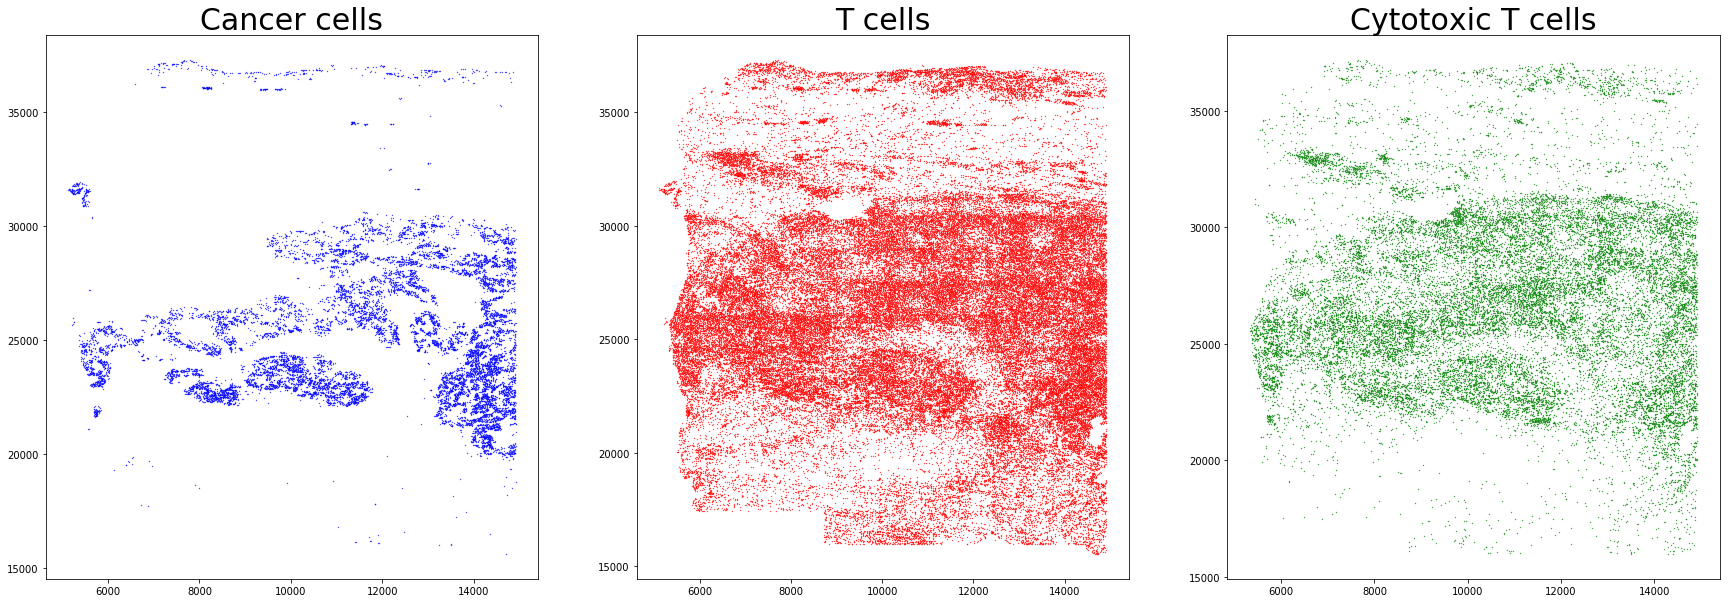

In [5]:
cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title('Cancer cells', fontsize=30)
ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

ax2.set_title('T cells', fontsize=30)
ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

ax3.set_title('Cytotoxic T cells', fontsize=30)
ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

plt.show(fig)

In [10]:
# Example cases for clustering algorithm
NUM_POINTS = 1000

def get_histo(du):
    histogram = np.zeros(21, dtype=np.uint32)
    total_cluster_cells = 0
    for i in du:
        if i is None:
            raise TypeError
        value = len(i.cells)
        total_cluster_cells += len(i.cells)
        if value > 20:
            histogram[20] += 1
        else:
            histogram[value - 1] += 1
    return histogram, total_cluster_cells

check_again = False

if not check_again:
#     random_xMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
    random_xMin = np.arange(NUM_POINTS)
    random_xMax = np.copy(random_xMin) + 3
#     random_yMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
    random_yMin = np.arange(NUM_POINTS)
    random_yMax = np.copy(random_yMin) + 3
    random_points = np.stack((random_xMin, random_xMax, random_yMin, random_yMax), 0).transpose()

t = 25
partitioned_random_points, windows_list, w, h = partition.partition(random_points, tile_size=t, to_list=True)
flattened_windows_list = np.array(windows_list).reshape((t*t, 4))

partitioned_total = 0
for i in range(t):
    for j in range(t):
        partitioned_total += len(partitioned_random_points[i][j])

assert(partitioned_total == NUM_POINTS)

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(random_points[:,0], random_points[:,2], s=5, c='g')
ax1.scatter(random_points[:,1], random_points[:,3], s=5, c='b')

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )

plt.show()

print("cleaning...")
Cluster_result1 = Cluster.simplest(random_points)
print("fishing...")
Cluster_result2 = Cluster.fishermans_algorithm(partitioned_random_points, t, windows_list, w, h)

dups1 = set()
dups2 = set()

# # Simplest
for key, value in Cluster_result1.items():
    if value not in dups1:
        dups1.add(value)

# # Fisherman's
for i in Cluster_result2:
    if i not in dups2:
        dups2.add(i)

assert(len(dups1) == len(dups2))
print("dups (length is %d):" % len(dups2))

histo1, total_cluster_cells1 = get_histo(dups1)
histo2, total_cluster_cells2 = get_histo(dups2)

if (total_cluster_cells1 != total_cluster_cells2) or not np.array_equal(histo1, histo2):
    print("ERROR")
    print(histo1)
    print(histo2)

NameError: name 'partition' is not defined

cluster <Cluster.Cluster object at 0x122c00eb8> .length:  1000


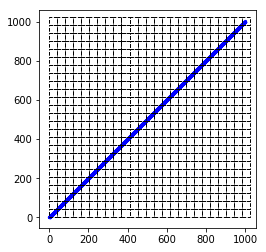

In [21]:
for cluster in dups1:
    cluster_points_xMin = np.array([item[0] for item in cluster.cells])
    cluster_points_xMax = np.array([item[1] for item in cluster.cells])
    cluster_points_yMin = np.array([item[2] for item in cluster.cells])
    cluster_points_yMax = np.array([item[3] for item in cluster.cells])
    print("cluster", cluster, ".length: ", len(cluster.cells))

    fig = plt.figure()
    ax1 = fig.add_subplot(111, aspect='equal')

    ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
    ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

    for window in flattened_windows_list:
        xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
        ax1.add_patch(
            patches.Rectangle(
                (xMin, yMin),   # (x,y)
                xMax - xMin,    # width
                yMax - yMin,    # height
                linestyle='--',
                fill=False
            )
        )
    plt.show()

In [9]:
t = 25
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
print("cells partitioned ...")

100%|██████████| 25/25 [00:00<00:00, 648.21it/s]

cells partitioned ...


In [10]:
# Starts off slowly, as we expect - comparing cells against pretty much every other cell.
# The iterations/s does increase over time though, due to the small optimisation that once we check a cell against
# all of its neighbours, we never check it again. This results in time complexity **roughly** of O(n^2 / 2).
cProfile.run("Cluster.simplest(cancer_cells)")

163it [00:04, 33.33it/s]


         2246384 function calls in 4.902 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:147(__enter__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:58(__init__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:78(acquire)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:936(_find_and_load_unlocked)
        1    0.000    0.

KeyboardInterrupt: 

In [22]:
# The fishermans algorithm as of 25/1/18 is M I L E S faster than the simple one above, completing in just 10 or so 
# seconds at most in comparison to ~3.5 minutes for the one above.
# This algorithm makes 2209284 neighbour comparisons in comparison to the above algorithm's 95268306.
# That's a difference of nearly 2 orders of magnitude already, and this is for a comparatively very small example. 
# Bigger ones, the gap becomes VAST. Investing time into developing this algorithm was definitely a wise move.
partitioned_random_points, windows, w, h = partition.partition(random_points, tile_size=t, to_list=True)
cProfile.run("Cluster.fishermans_algorithm(partitioned_random_points, t, windows, w, h)")

100%|██████████| 25/25 [00:00<00:00, 61.22it/s]/s]


         67568 function calls in 0.411 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:147(__enter__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:58(__init__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:78(acquire)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:936(_find_and_load_unlocked)
       26    0.000    0.00

In [12]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
result = Cluster.fishermans_algorithm(partitioned_cancer_cells, t, windows, w, h)

tile_numbers = []
dups = []
histogram = np.zeros(21, dtype=np.uint32)

for i in range(t):
    for j in range(t):
        num = 0
        for value in result:
            if value not in dups:
                dups.append(value)
            num += 1
        tile_numbers.append(num)
        
print("dups (length is %d):" % len(dups))
total_cluster_cells = 0

clusters_sum = 0
dups_length = len(dups)

for i in dups:
    value = len(i.cells)
    clusters_sum += value
    total_cluster_cells += len(i.cells)
    if value > 20:
        histogram[20] += 1
    else:
        histogram[value - 1] += 1
                
clusters_avg = clusters_sum / dups_length

print("Total number of cells:", total_cluster_cells)

print(histogram)
    
y = np.array(histogram)
x = np.arange(21) + 1

100%|██████████| 25/25 [00:08<00:00,  3.00it/s]s]


dups (length is 2644):
Total number of cells: 13804
[1275  444  223  138   89   68   51   49   30   22   21   17   16   15
   10   17   12    9    7   13  118]


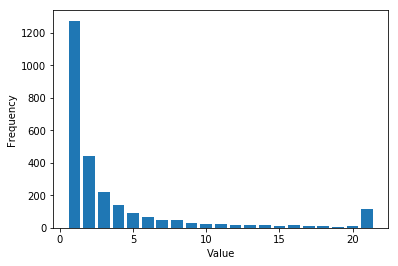

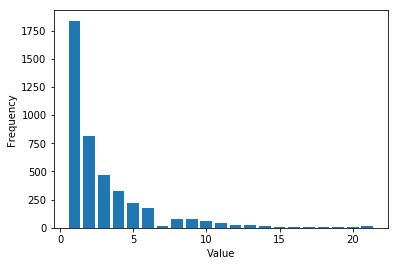

In [13]:
fig = plt.figure()

plt.bar(x, y)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

y = np.array([1838, 817, 467, 324, 223, 172, 13, 80, 79, 61, 42, 29, 21, 20, 8, 7, 11, 8, 6, 6, 18])

plt.bar(x, y)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# for cluster in dups:
#     cluster_points_xMin = np.array([item[0] for item in cluster.cells])
#     cluster_points_xMax = np.array([item[1] for item in cluster.cells])
#     cluster_points_yMin = np.array([item[2] for item in cluster.cells])
#     cluster_points_yMax = np.array([item[3] for item in cluster.cells])
#     print("cluster", cluster, ".length: ", len(cluster.cells))

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111, aspect='equal')

#     ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
#     ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

#     for window in windows_list:
#         xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#         ax1.add_patch(
#             patches.Rectangle(
#                 (xMin, yMin),   # (x,y)
#                 xMax - xMin,    # width
#                 yMax - yMin,    # height
#                 linestyle='--',
#                 fill=False
#             )
#         )
#     plt.show()

In [4]:
import imblearn
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn import decomposition
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.base import SamplerMixin
import glob


# Note to self: reference this in final report submission.
# @article{JMLR:v18:16-365,
# author  = {Guillaume  Lema{{\^i}}tre and Fernando Nogueira and Christos K. Aridas},
# title   = {Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning},
# journal = {Journal of Machine Learning Research},
# year    = {2017},
# volume  = {18},
# number  = {17},
# pages   = {1-5},
# url     = {http://jmlr.org/papers/v18/16-365}
# }

In [86]:
X, y = make_classification(n_samples=59, n_features=2, n_informative=2,
                            n_redundant=0, n_repeated=0, n_classes=2,
                            n_clusters_per_class=1,
                            weights=[0.06, 0.94],
                            class_sep=0.8, random_state=1)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 55), (1, 55)]


In [87]:
clf = LinearSVC()
clf.fit(X_resampled, y_resampled)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [ ]:
def plot_decision_function(X, y, clf, ax):
    print("at start of plot_decision_function")
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    print("maxes and mins defined")
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    print("in middle of plot_decision_function")
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    print("at end of plot_decision_function")

fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 6))
plot_decision_function(X_resampled, y_resampled, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
fig.tight_layout()

In [228]:
# This is it! Our real dataset.
X = np.empty([59, 21], dtype=np.float32)

for i, file in enumerate(glob.glob("./inputs/*.txt")):
    f = open(file,'r')
    lines = f.readlines()[4:]
    arr = np.zeros(21, dtype=np.float32)
    for x, line in enumerate(lines):
        arr[x] = int(line.split(',')[1])
    X[i] = arr

y = np.zeros([59], dtype=np.float32)
positives = [4, 8, 16, 28, 56]

for index in positives:
    y[index] = 1

In [229]:
for i, example in enumerate(X):
    my_sum = sum(example)
    mean = my_sum / example.size
    
    for j, value in enumerate(example):
        X[i][j] = (value - mean) / (max(example) - min(example))
    
X

array([[ 0.9172533 ,  0.69961715,  0.38477057, ..., -3.1714916 ,
        -3.2169974 , -2.308973  ],
       [ 0.90110433,  0.6766522 ,  0.2857983 , ..., -0.43531612,
        -0.4361841 ,  0.5214973 ],
       [ 0.91387844,  0.7135301 ,  0.3876668 , ..., -1.2503949 ,
        -1.2503818 , -0.3143963 ],
       ...,
       [ 0.9159821 ,  0.6986656 ,  0.3820317 , ..., -1.1256546 ,
        -1.1306591 , -0.183093  ],
       [ 0.9274115 ,  0.69424766,  0.27066392, ..., -2.788499  ,
        -2.7938411 , -1.876351  ],
       [ 0.91211283,  0.6787768 ,  0.361493  , ..., -0.6766392 ,
        -0.6757697 ,  0.2819401 ]], dtype=float32)

In [230]:
clf = LinearSVC()
clf.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [260]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
clf.fit(X, y)

Pipeline(memory=None,
     steps=[('smote', SMOTE(k=None, k_neighbors=4, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=0, ratio='auto', svm_estimator=None)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

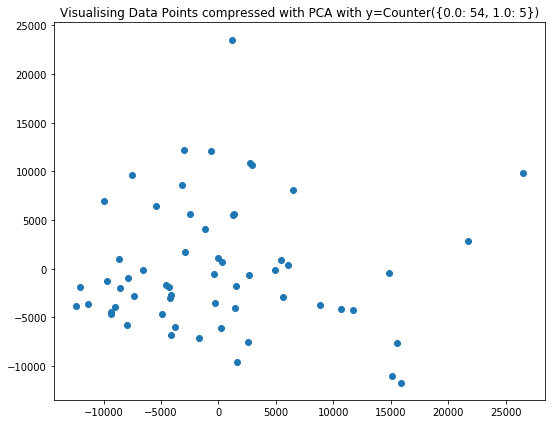

In [261]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 6))
# plot_decision_function(X, y, clf, ax1)
ax1.scatter(X[:, 0], X[:, 1])
ax1.set_title('Visualising Data Points compressed with PCA with y={}'.format(Counter(y)))
fig.tight_layout()

In [262]:
# # X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
# # sampler = FakeSampler()
# # clf = make_pipeline(sampler, LinearSVC())

# sampler = SMOTE(random_state=0)
# clf = make_pipeline(sampler, LinearSVC())
# print(clf)

# X_train = X
# y_train = y

# clf.fit(X_train, y_train)

# X_res, y_res = sampler.fit_sample(X_train, y_train)
# plt.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
# # make nice plotting
# plt.spines['top'].set_visible(False)
# plt.spines['right'].set_visible(False)
# plt.get_xaxis().tick_bottom()
# plt.get_yaxis().tick_left()
# plt.spines['left'].set_position(('outward', 10))
# plt.spines['bottom'].set_position(('outward', 10))

(59, 2) (59,)


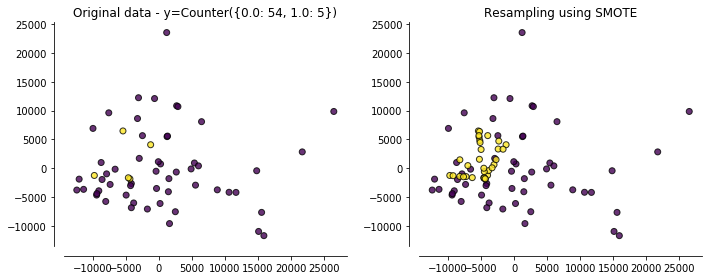

In [265]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

# def plot_decision_function(X, y, clf, ax):
#     plot_step = 0.02
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
#                          np.arange(y_min, y_max, plot_step))

#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     ax.contourf(xx, yy, Z, alpha=0.4)
#     ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

class FakeSampler(SamplerMixin):

    def fit(self, X, y):
        self.ratio_ = 1
        self.X_hash_ = hash_X_y(X, y)
        return self

    def sample(self, X, y):
        return X,

    def _sample(self, X, y):
        pass

    def fit_sample(self, X, y):
        return X, y

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 4))
print(X.shape, y.shape)
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_resampling(X, y, sampler, ax2)
ax2.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

(59, 625)


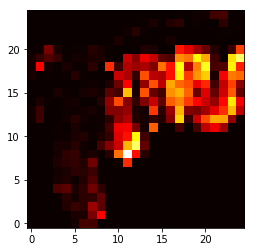

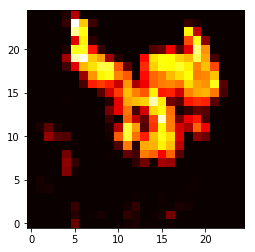

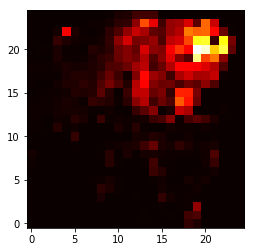

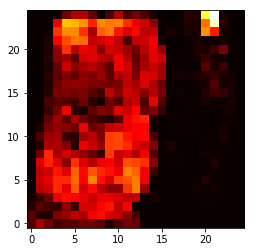

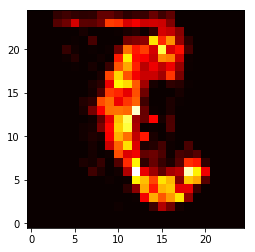

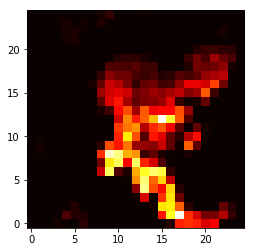

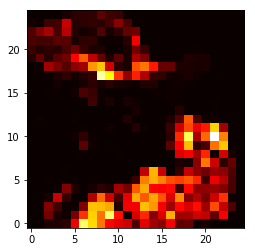

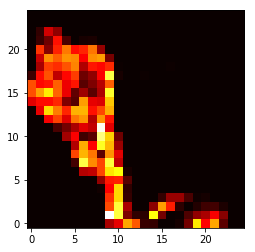

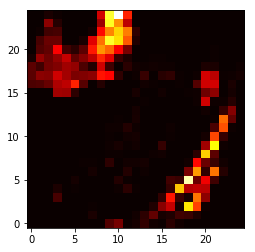

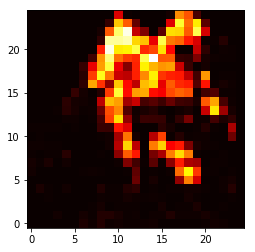

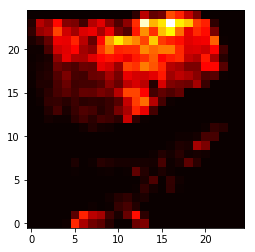

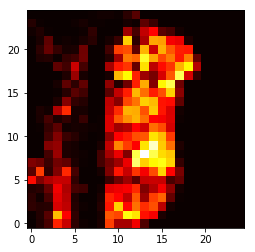

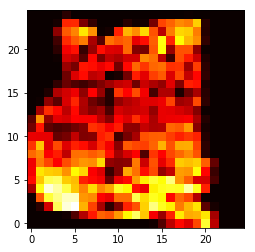

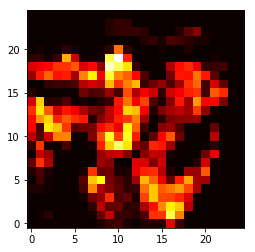

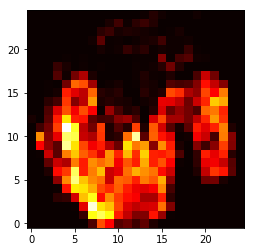

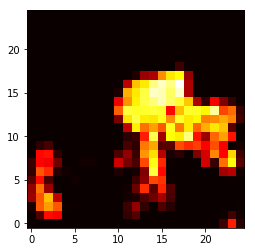

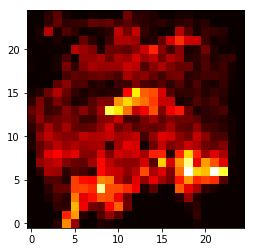

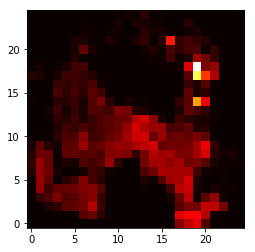

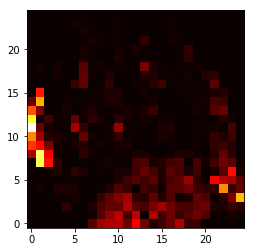

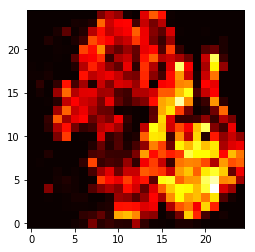

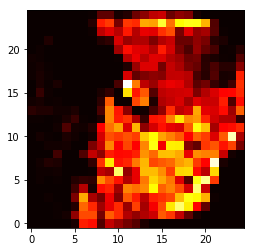

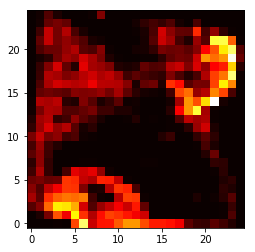

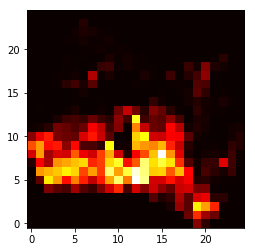

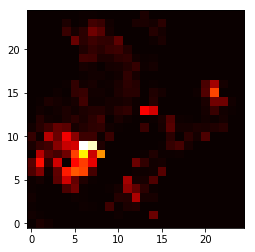

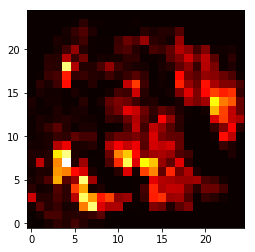

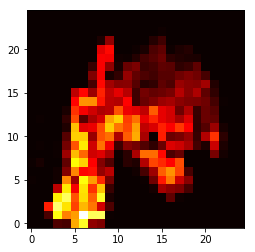

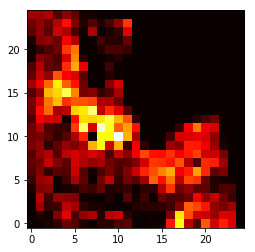

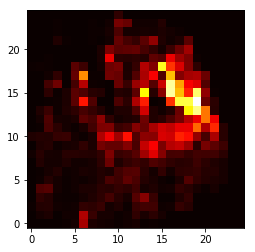

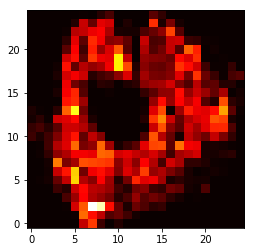

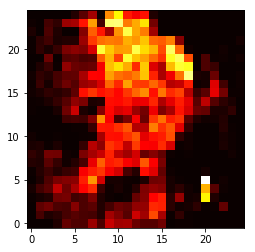

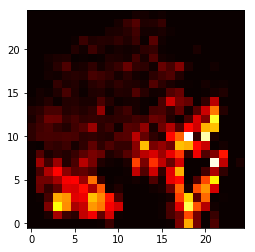

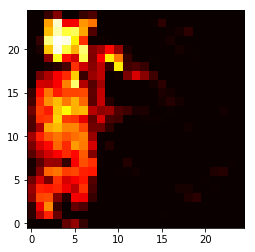

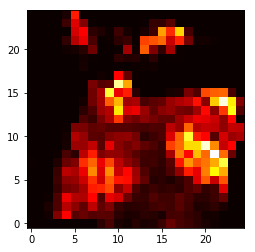

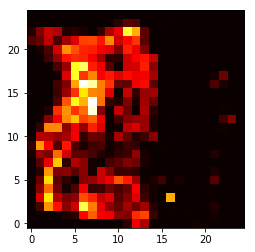

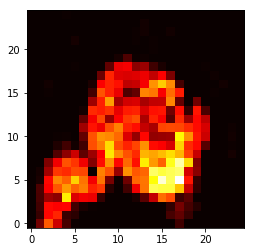

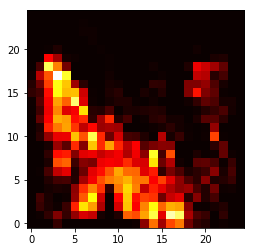

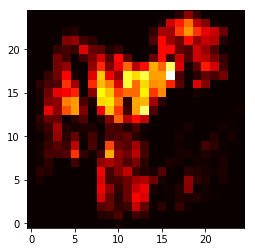

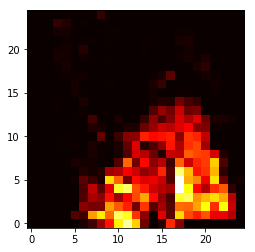

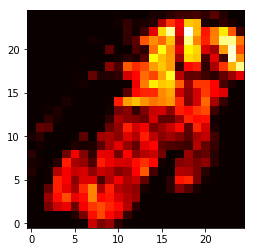

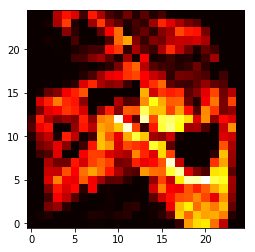

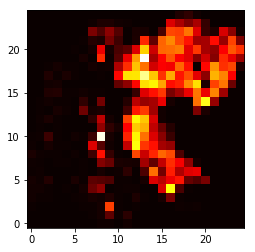

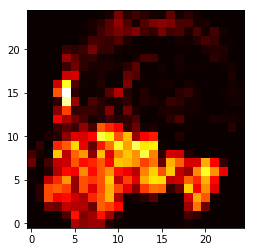

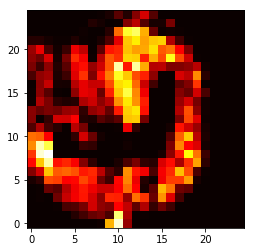

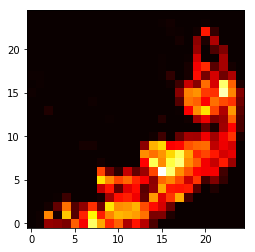

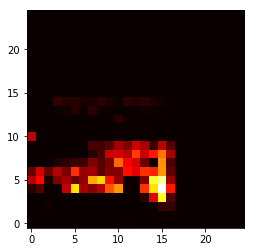

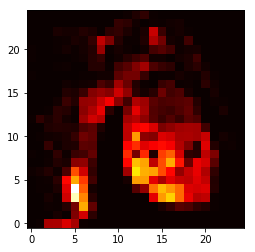

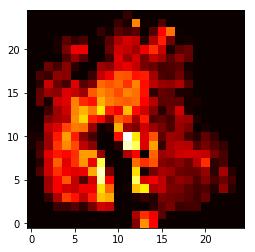

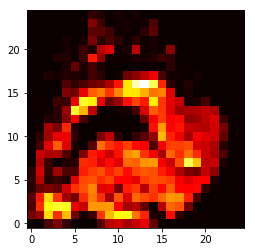

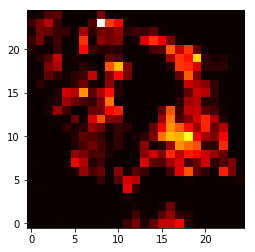

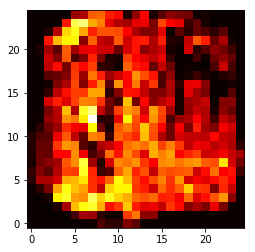

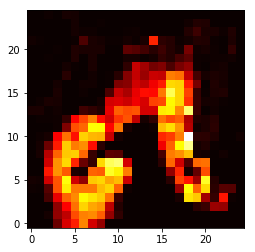

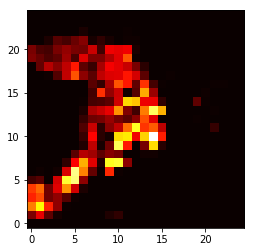

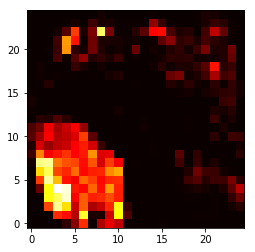

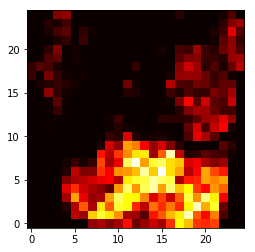

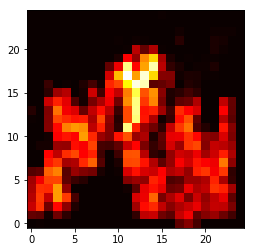

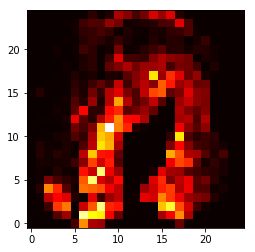

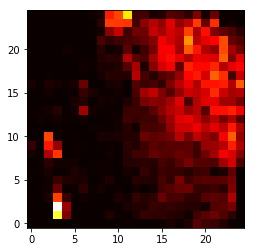

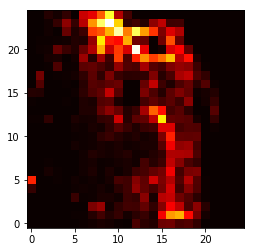

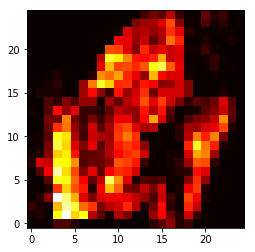

In [271]:
X = np.empty((59, 625))

for i, file in enumerate(glob.glob("./inputs/spatial/*.txt")):
    f = open(file,'r')
    lines = f.readlines()
    arr = np.zeros((25, 25), dtype=np.float32)
    
    arr_i = 0
    to_skip = []
    for x, line in enumerate(lines):
        if ']' in line and x not in to_skip:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            arr[arr_i] = np.array([int(s) for s in cleaned.split() if s.isdigit()])
            arr_i += 1
        elif ']' not in line:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            build_list = [int(s) for s in cleaned.split() if s.isdigit()]
            index = x
            while ']' not in line:
                index += 1
                to_skip.append(index)
                line = lines[index]
                cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
                build_list.extend([int(s) for s in cleaned.split() if s.isdigit()])
            arr[arr_i] = np.array(build_list)
            arr_i += 1
    
    arr = arr.reshape(625)
    
    my_sum = sum(arr)
    mean = my_sum / arr.size
    stddev = np.std(arr)
    
    for j, value in enumerate(arr):
        arr[j] = (value - mean)  # / stddev

    X[i] = arr

print(X.shape)
y = np.zeros([59], dtype=np.float32)
positives = [4, 8, 16, 28, 56]

for index in positives:
    y[index] = 1

for (i, pair) in enumerate(zip(X, glob.glob("./inputs/spatial/*.txt"))):
    (matrix, name) = pair
    temp = np.array([[int(el) for el in matrix]]).reshape(25, 25).transpose()
    fig = plt.figure()
    plt.imshow(temp, cmap='hot', origin='lower')
    plt.imsave('./inputs/spatial/heatmaps/' + name[17:-4] + '.png', temp, origin='lower', cmap='hot')
    plt.show()